In [83]:
import pandas as pd
import numpy as np 
from math import * 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy 

STOCK_NAME = "sbux"
equity_data = pd.read_csv(STOCK_NAME + " test data.csv")
rf_data = pd.read_csv("rf rate " + STOCK_NAME + ".csv")
data = equity_data.merge(rf_data, left_on='date', right_on='date')
#data = pd.merge(equity_data, rf_data, on='date', how='left')
data["real returns"] = data['RET'] - data['rf'] + 1
data['spr real returns'] = data['sprtrn'] - data['rf'] + 1
data['month'] = data['date'].str[:-3]
data['year'] = data['date'].str[:-6]
monthly_trades = data.groupby('month')["NUMTRD"].mean()
data['monthly avg trade'] = data.groupby('month')['NUMTRD'].transform('mean')

PERMNO                     77702
date                  1998-12-01
RET                     0.085366
NUMTRD                    4035.0
sprtrn                  0.010012
rf                       0.00017
real returns            1.085196
spr real returns        1.009842
month                    1998-12
year                        1998
monthly avg trade    1345.545455
Name: 1622, dtype: object


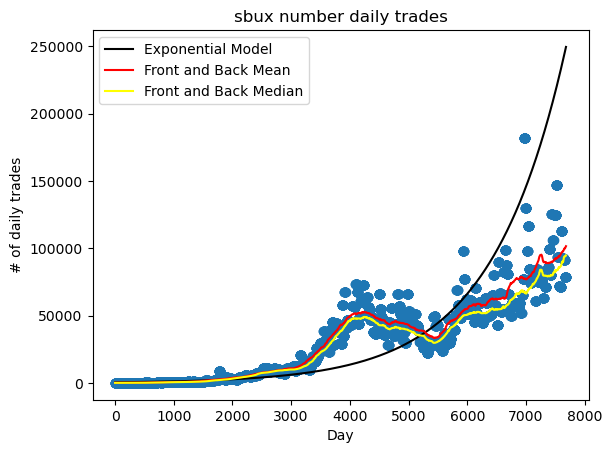

In [84]:
#some trading days had only 0 or 1, either bugs or not they mess stuff up
data["NUMTRD"].fillna(value=0)
print(data.iloc[1622])
data = data[data["NUMTRD"] > 1]
#y_data = data["NUMTRD"].to_numpy()
y_data = data['monthly avg trade']
#print(y_data)
y_data_log = np.log(y_data)
x_data = np.arange(1, y_data.shape[0]+1, 1)
x_data_reshaped = x_data.reshape(-1,1)

#Might want a better fit algorithm 
lin_reg = LinearRegression()
lin_reg.fit(x_data_reshaped, y_data_log)
          
# Generate points for plotting the linear regression line in log scale
y_model_log = lin_reg.predict(x_data_reshaped)
y_model = np.exp(y_model_log)

plt.scatter(x_data, y_data)
plt.plot(x_data_reshaped, y_model, color="black", zorder=2, label='Exponential Model')

plt.ylabel("# of daily trades")
plt.xlabel("Day")

# Modified function to take a Pandas Series (a single column from a DataFrame) as input
def calculate_average(series, window):
    # Extended series with NaNs for handling edge cases
    extended_series = pd.Series([np.nan] * window + series.tolist() + [np.nan] * window)
    
    # List to store the results
    averages = []

    for i in range(len(series)):
        # Calculate the window range
        start_index = i
        end_index = i + 2 * window + 1

        # Extract the window values, ignoring NaNs
        window_values = extended_series[start_index:end_index].dropna()

        # Calculate the average
        if len(window_values) > 0:
            avg = window_values.mean()
        else:
            avg = np.nan
        
        averages.append(avg)

    return averages

# Applying the function to a single column of the DataFrame
window_size = 300  # Change this value as needed
data['trading moving average'] = calculate_average(data['NUMTRD'], window_size)
plt.plot(data[['trading moving average']], color='red', label='Front and Back Mean')

# Modified function for median smoothing
def median_smoothing(series, window):
    # Extended series with NaNs for handling edge cases
    extended_series = pd.Series([np.nan] * window + series.tolist() + [np.nan] * window)
    
    # List to store the results
    medians = []

    for i in range(len(series)):
        # Calculate the window range
        start_index = i
        end_index = i + 2 * window + 1

        # Extract the window values, ignoring NaNs
        window_values = extended_series[start_index:end_index].dropna()

        # Calculate the median
        if len(window_values) > 0:
            med = window_values.median()
        else:
            med = np.nan
        
        medians.append(med)

    return medians

# Applying the median smoothing function to the same large DataFrame
data['trading moving median'] = median_smoothing(data['NUMTRD'], window_size)
plt.plot(data[['trading moving median']], color='yellow', label='Front and Back Median')
plt.title(STOCK_NAME + " number daily trades")
plt.legend()

Exponential Model Ratio: 
1.3080926758442402
Moving Average Model Ratio: 
0.9834613193394921
Moving Median Model Ratio: 
1.1226874937724887


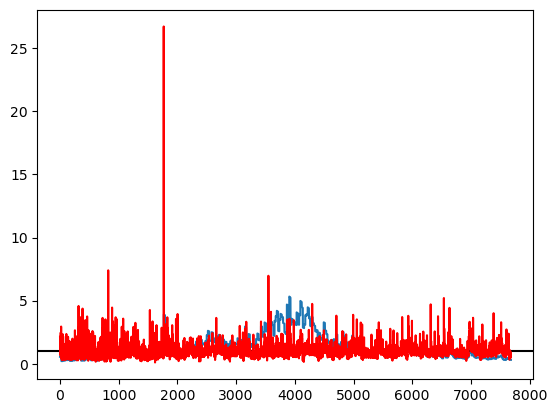

In [85]:
sum_trades = np.sum(y_data)
num_days = y_data.shape[0]

def calculate_exponential_fit(x, lin_reg):
    # Reshape x for sklearn if it's a 1-D array
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    
    # Predict the log of y using the linear regression model
    y_log_pred = lin_reg.predict(x)
    
    # Return the exponential of the prediction to get back to the original scale
    return np.exp(y_log_pred)

# Calculate the predicted y values for the new x values
predicted_y_values = calculate_exponential_fit(x_data, lin_reg)
normalized_trading = np.divide(y_data,predicted_y_values)
print("Exponential Model Ratio: ")
print(np.sum(normalized_trading)/num_days)
plt.plot(normalized_trading)
plt.axhline(1, color="black")
#should we maybe just adjust it down by the ratio to finish it or fix the model? 

normalized_trading_2 = (data['NUMTRD'] / data['trading moving average']).to_numpy()
plt.plot(normalized_trading_2, color='red')

print("Moving Average Model Ratio: ")
print(np.sum(normalized_trading_2) / num_days)

normalized_trading_3 = (data['NUMTRD'] / data['trading moving median']).to_numpy()
print("Moving Median Model Ratio: ")
print(np.sum(normalized_trading_3)/num_days)

Text(0.5, 1.0, 'sbux Cumulative Sum of Normalized Trading')

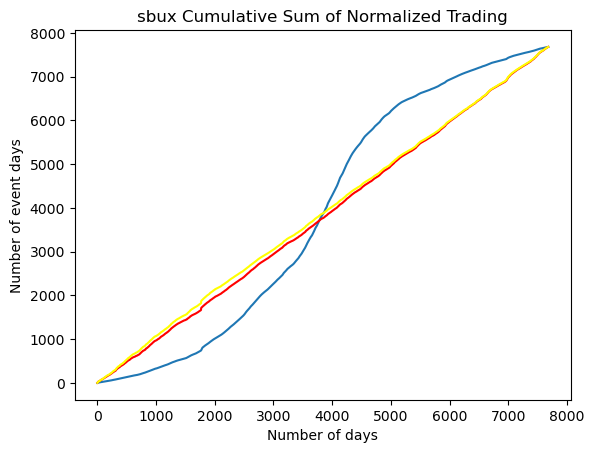

In [86]:
normalized_trading_scaled = normalized_trading * normalized_trading.shape[0]/np.sum(normalized_trading)
normalized_trading_scaled_2 = normalized_trading_2 * normalized_trading_2.shape[0]/np.sum(normalized_trading_2)
normalized_trading_scaled_3 = normalized_trading_3 * normalized_trading_3.shape[0]/np.sum(normalized_trading_3)

cum_sum = np.cumsum(normalized_trading_scaled)
plt.plot(cum_sum)
plt.plot(np.cumsum(normalized_trading_scaled_2), color='red')
plt.plot(np.cumsum(normalized_trading_scaled_3), color='yellow')

normalized_trading_scaled = normalized_trading_scaled_3 #median

num_events = len(data.groupby('month').sum())
trades_per_month = np.sum(normalized_trading_scaled)/(num_events)
new_blocks = np.empty(num_events, dtype=int)
current_sum = 0 
counter = 0
for i in range(normalized_trading_scaled.size):
    current_sum += normalized_trading_scaled[i]
    if(current_sum > trades_per_month):
        current_sum -= trades_per_month 
        new_blocks[counter] = i
        counter += 1
#last one is end 
new_blocks[-1] = normalized_trading_scaled.size-1
plt.ylabel("Number of event days")
plt.xlabel("Number of days")
plt.title(STOCK_NAME + " Cumulative Sum of Normalized Trading")

[1.24461311 0.90780709 1.12575017 1.03201001 1.24696062 1.00692194
 1.02475306 0.94531944 1.07244013 1.13176349 1.09329763 1.01836522
 0.92754874 1.06236391 1.08963283 1.00845875 0.95141151 0.89172588
 0.84570801 1.22873139 0.93463879 1.06976676 1.23009144 0.97273864
 1.006013   0.84400454 1.16961116 0.99564851 0.79992219 1.04448245
 1.15057526 0.90028346 1.0239774  0.86645648 1.16229195 1.08852653
 1.15243906 1.12901777 1.06545049 0.97319451 0.94270483 0.94499699
 1.23464045 1.03062112 0.73600732 0.89815142 1.12232629 1.28618049
 1.16511299 1.07750493 0.96827563 0.90848803 1.21415189 1.16774366
 0.99000449 0.96358787 0.88656314 0.97977742 1.22360667 0.8273077
 0.88218453 1.04207494 1.04874905 1.30325914 0.94770196 1.06151187
 1.07099672 0.90301953 0.86573794 1.12041028 0.91488096 1.1000976
 1.17306837 1.07789063 1.16694348 0.69675834 0.84237175 0.95965772
 1.03398977 1.42619218 0.98348899 1.12963527 1.02845032 1.08300913
 1.12144009 1.03470612 0.74682189 1.023022   0.90668634 0.955596

Text(0.5, 1.0, 'Exponential Model')

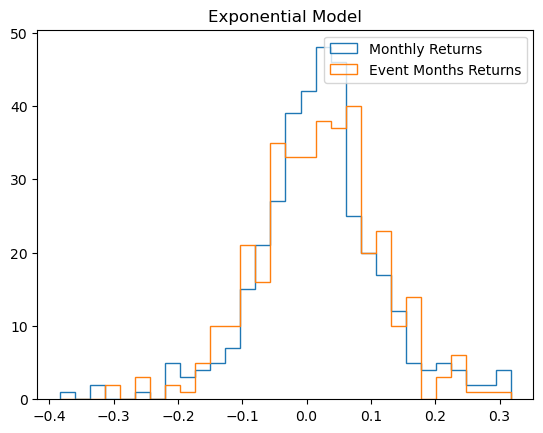

In [87]:
#calculate monthly returns 
equity_event_month_returns = np.ones(num_events)
sp_event_month_returns = np.ones(num_events)
counter = 0 
data["sprtrn"] += 1
for index, val in enumerate(data["real returns"].to_numpy()):
    equity_event_month_returns[counter] *= val
    if index == new_blocks[counter]:
        counter += 1
counter = 0
for index, val in enumerate(data["spr real returns"].to_numpy()):
    sp_event_month_returns[counter] *= (val)
    if index == new_blocks[counter]:
        counter += 1

equity_monthly_returns = data.groupby('month')["real returns"].prod().to_numpy()
sp_monthly_returns = data.groupby('month')["spr real returns"].prod().to_numpy()
_, bins, _, = plt.hist(equity_monthly_returns - 1, bins=30, histtype=u'step', label="Monthly Returns")
plt.hist(equity_event_month_returns - 1, bins=bins,  histtype=u'step', label="Event Months Returns")
plt.legend()
print(equity_event_month_returns)
plt.title("Exponential Model")

[0.02275056]
[0.01198805]


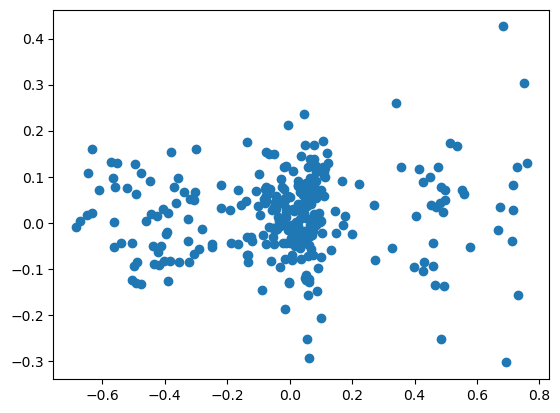

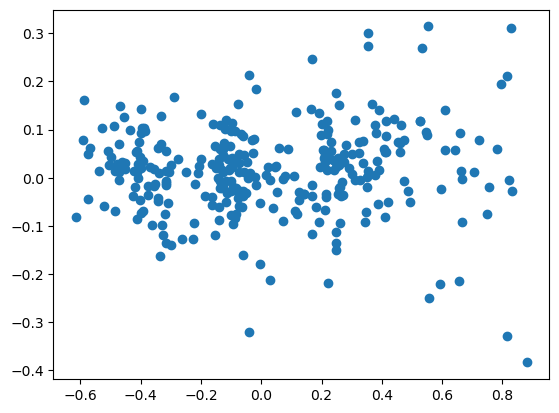

In [89]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.metrics import r2_score

capm_event_month = RollingOLS(pd.Series(equity_event_month_returns - 1), pd.Series(sp_event_month_returns - 1), 
                               window=60)

capm_monthly = RollingOLS(pd.Series(equity_monthly_returns - 1), pd.Series(sp_monthly_returns - 1), 
                               window=60)

event_month_betas = capm_event_month.fit(params_only=True).params.to_numpy().reshape(1, -1)[0]
monthly_betas = capm_monthly.fit(params_only=True).params.to_numpy().reshape(1, -1)[0]

actual_event_month_returns = equity_event_month_returns[61:] - 1 #need to check this
actual_monthly_returns = equity_monthly_returns[61:] - 1 #need to check this 

expected_event_month_returns = np.multiply(event_month_betas[1:],sp_event_month_returns[-1:])
expected_monthly_returns = np.multiply(monthly_betas[1:],sp_monthly_returns[:-1])
expected_event_month_returns = expected_event_month_returns[60:] - 1
expected_monthly_returns = expected_monthly_returns[60:] - 1

plt.scatter(expected_event_month_returns, actual_event_month_returns)
plt.figure()
plt.scatter(expected_monthly_returns, actual_monthly_returns)


event_month_model = LinearRegression().fit(expected_event_month_returns.reshape(-1,1), actual_event_month_returns.reshape(-1,1))
event_month_model_pred = event_month_model.predict(expected_event_month_returns.reshape(-1,1))
event_month_model_slope = event_month_model.coef_[0]
# Calculate R² coefficient
r2_event_month = r2_score(actual_event_month_returns.reshape(-1,1), event_month_model_pred.reshape(-1,1))


monthly_model = LinearRegression().fit(expected_monthly_returns.reshape(-1,1), actual_monthly_returns.reshape(-1,1))
monthly_model_pred = monthly_model.predict(expected_monthly_returns.reshape(-1,1))
monthly_model_slope = monthly_model.coef_[0]
# Calculate R² coefficient
r2_monthly = r2_score(actual_monthly_returns.reshape(-1,1), monthly_model_pred.reshape(-1,1))

print(event_month_model_slope)
print(monthly_model_slope)